# *Traffic Sign Recognizer - Shenfan Feng*

## Importing Required Libraries

In [23]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import LearningRateScheduler

from matplotlib import style
style.use('fivethirtyeight')

## Assigning Path for Dataset

In [24]:
data_dir = '/Users/zayn/Downloads/archive'
train_path = '/Users/zayn/Downloads/archive/Train'
test_path = '/Users/zayn/Downloads/archive/'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes

In [25]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [26]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

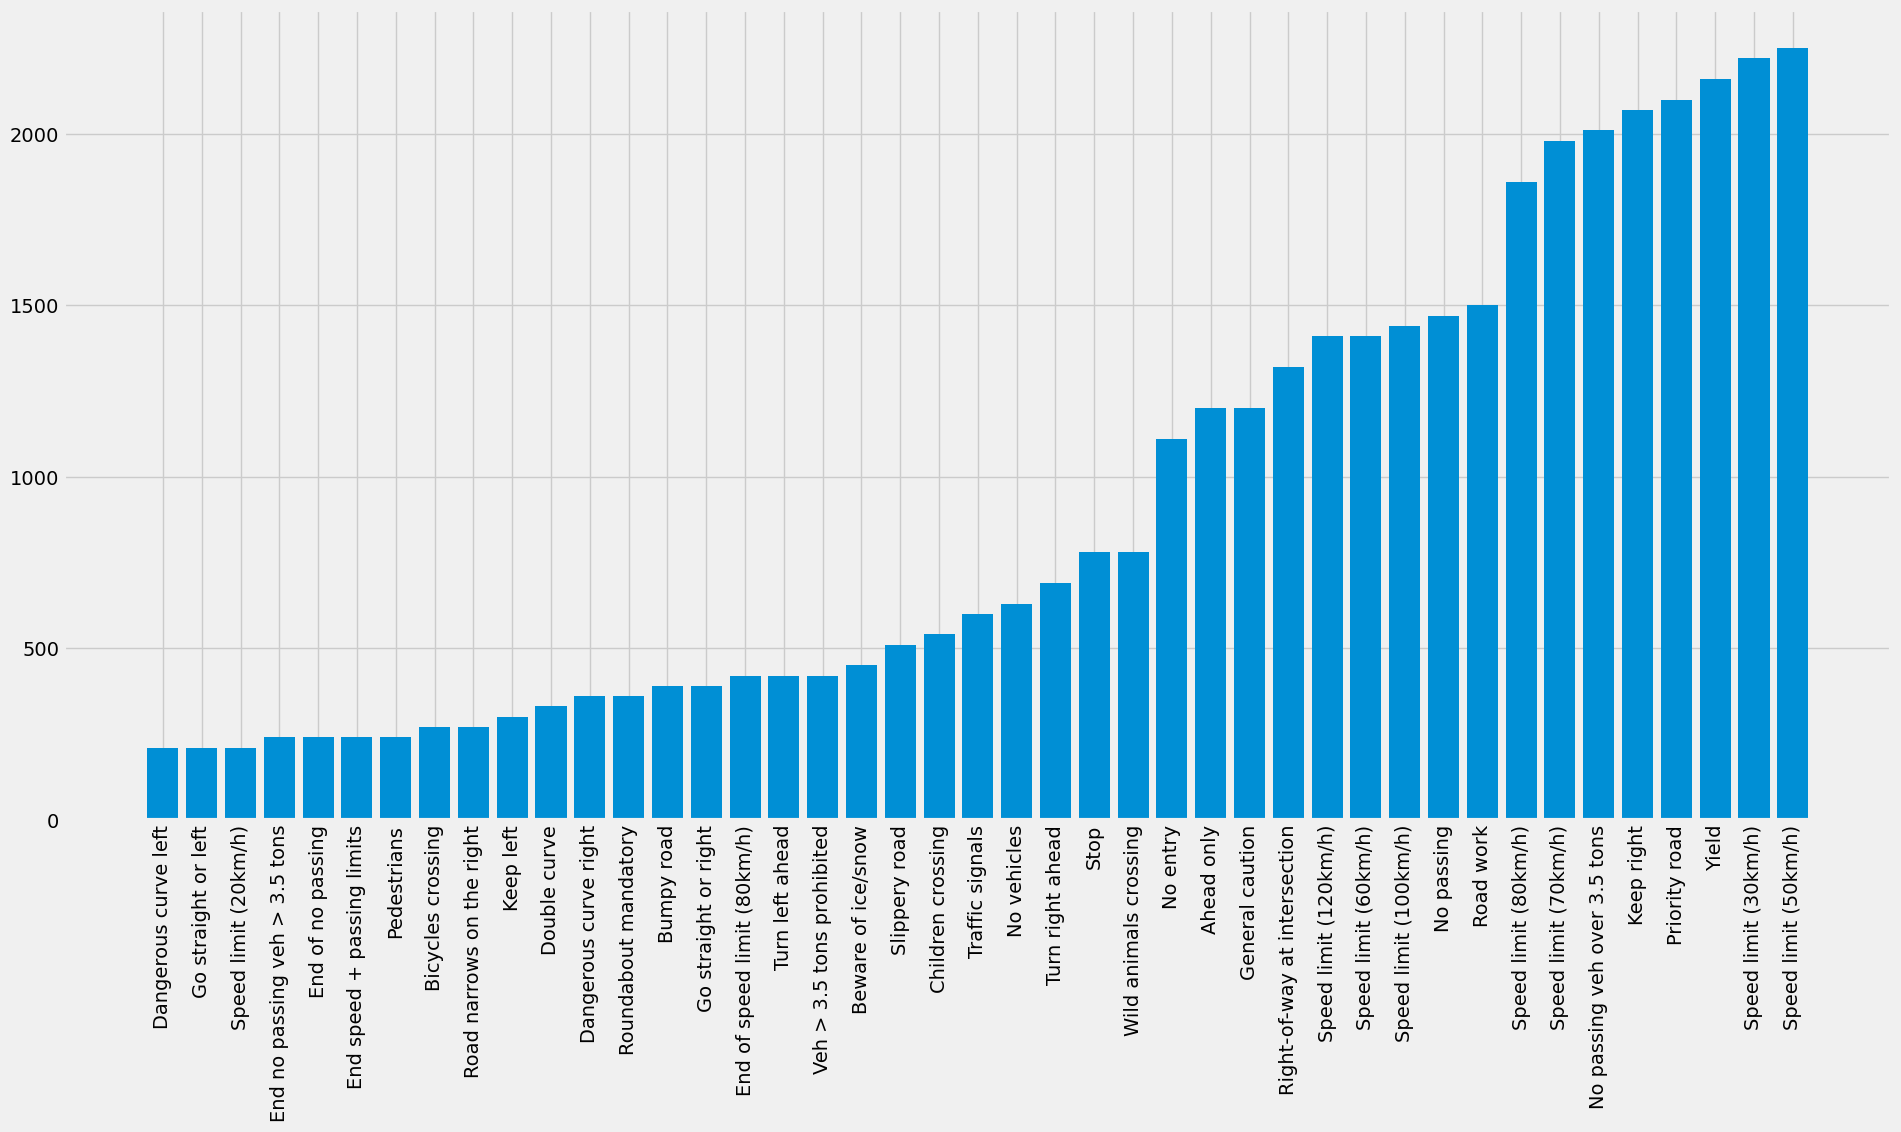

In [27]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

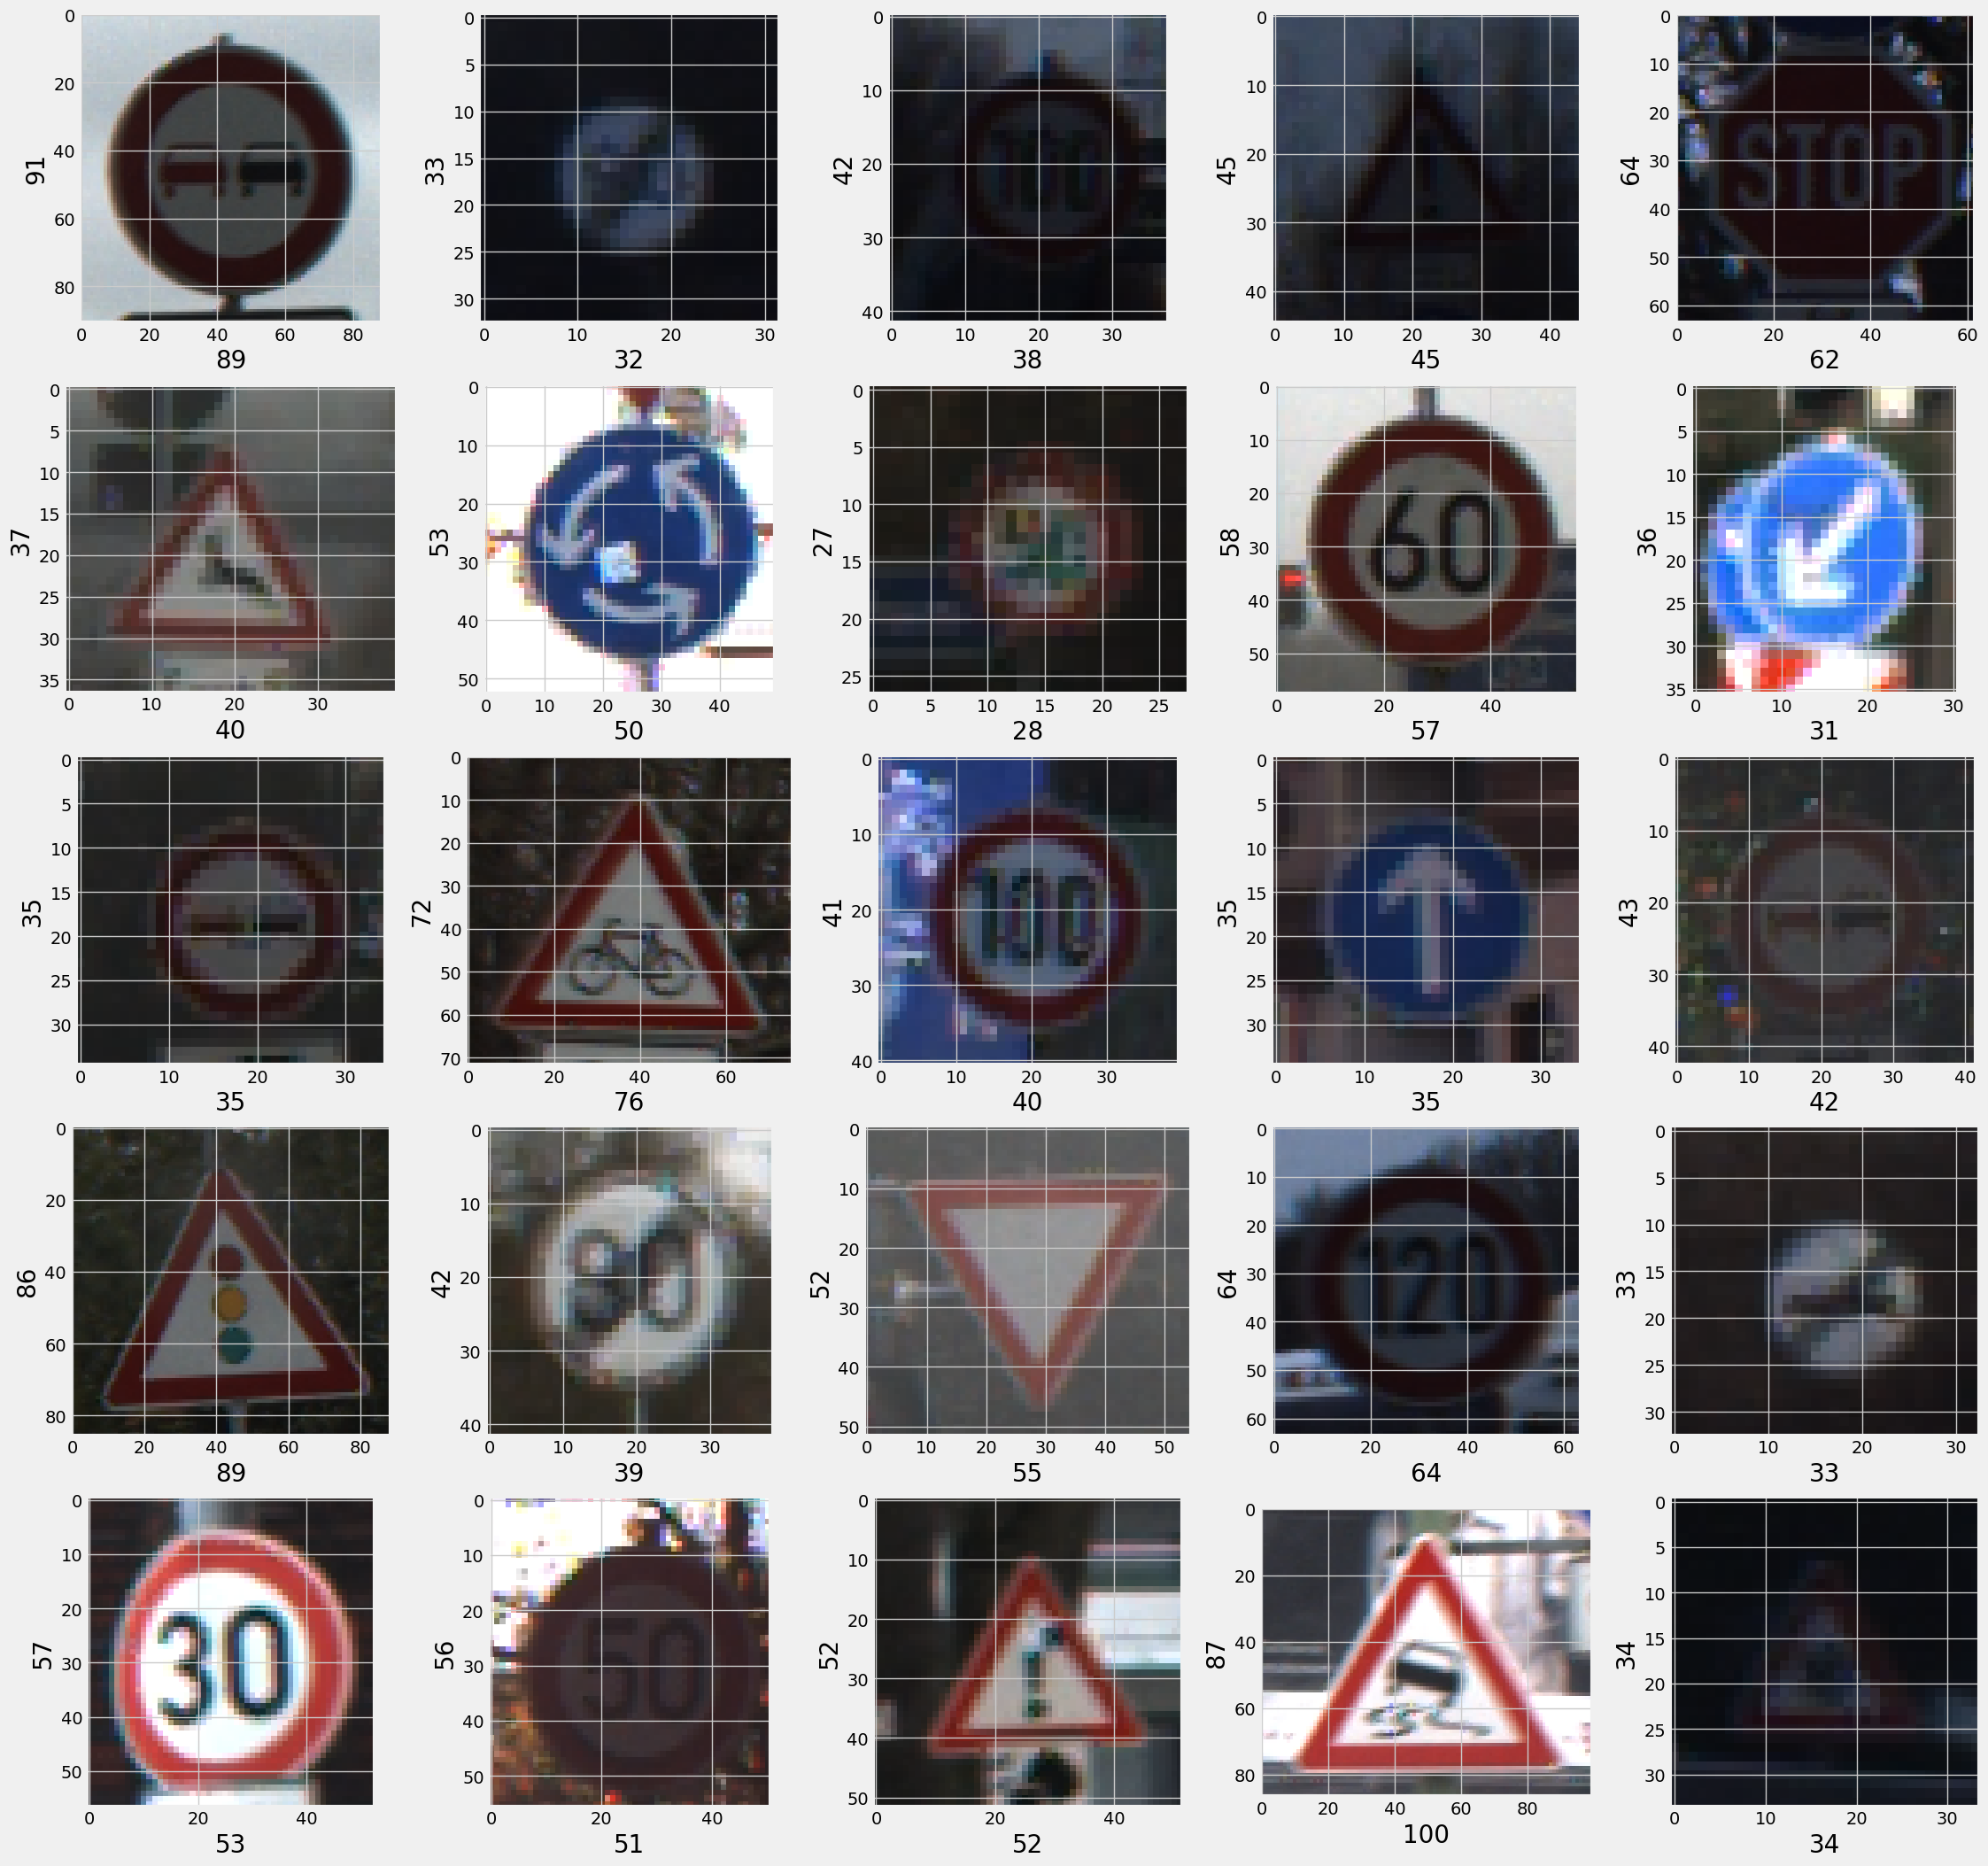

In [28]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data

In [29]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the training data

In [30]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [31]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding the labels

In [32]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Making the model

In [33]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [34]:
# lr = 0.001
# epochs = 30

# opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

lr = 0.001
epochs = 30

def scheduler(epoch, lr):
    if epoch < epochs * 0.5:
        return lr
    else:
        return lr * 0.5

lr_scheduler = LearningRateScheduler(scheduler)

opt = Adam(learning_rate=lr)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Augmenting the data and training the model

In [35]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30


2023-11-26 00:57:58.488287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-26 00:57:58.523932: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


858/858 [==============================] - 22s 25ms/step - loss: 1.1593 - accuracy: 0.6869 - val_loss: 0.1074 - val_accuracy: 0.9691
Epoch 2/30
858/858 [==============================] - 22s 26ms/step - loss: 0.1964 - accuracy: 0.9392 - val_loss: 0.0618 - val_accuracy: 0.9828
Epoch 3/30
858/858 [==============================] - 24s 27ms/step - loss: 0.1065 - accuracy: 0.9677 - val_loss: 0.0290 - val_accuracy: 0.9914
Epoch 4/30
858/858 [==============================] - 25s 30ms/step - loss: 0.0932 - accuracy: 0.9717 - val_loss: 0.0186 - val_accuracy: 0.9943
Epoch 5/30
858/858 [==============================] - 24s 28ms/step - loss: 0.0795 - accuracy: 0.9760 - val_loss: 0.0279 - val_accuracy: 0.9918
Epoch 6/30
858/858 [==============================] - 23s 27ms/step - loss: 0.0705 - accuracy: 0.9775 - val_loss: 0.0228 - val_accuracy: 0.9932
Epoch 7/30
858/858 [==============================] - 24s 28ms/step - loss: 0.0583 - accuracy: 0.9816 - val_loss: 0.0194 - val_accuracy: 0.9954
Epo

## Evaluating the model

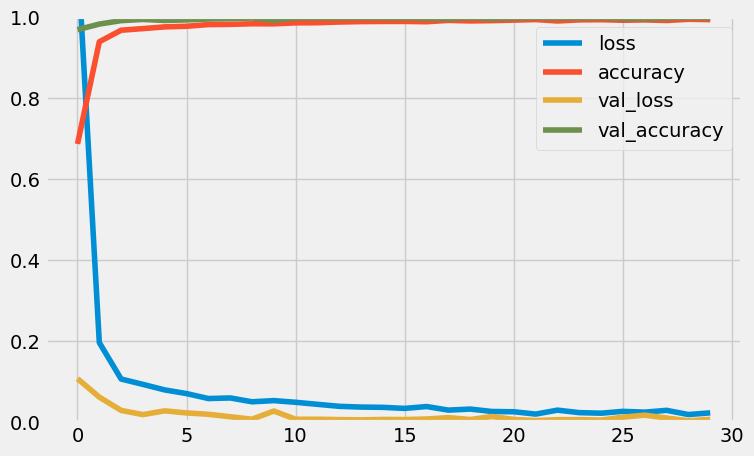

In [36]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions

In [41]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict(X_test)  # 使用 model.predict 而不是 predict_classes
pred_classes = np.argmax(pred, axis=1)  # 从预测结果中提取类别索引

# 计算测试数据的准确率
print('Test Data accuracy: ', accuracy_score(labels, pred_classes) * 100)

395/395 [==============================] - 3s 7ms/step
Test Data accuracy:  98.13935075217735


## Visualizing the confusion matrix

In [42]:
from sklearn.metrics import confusion_matrix
pred_classes = np.argmax(pred, axis=1)

# 计算混淆矩阵
cf = confusion_matrix(labels, pred_classes)

<Axes: >

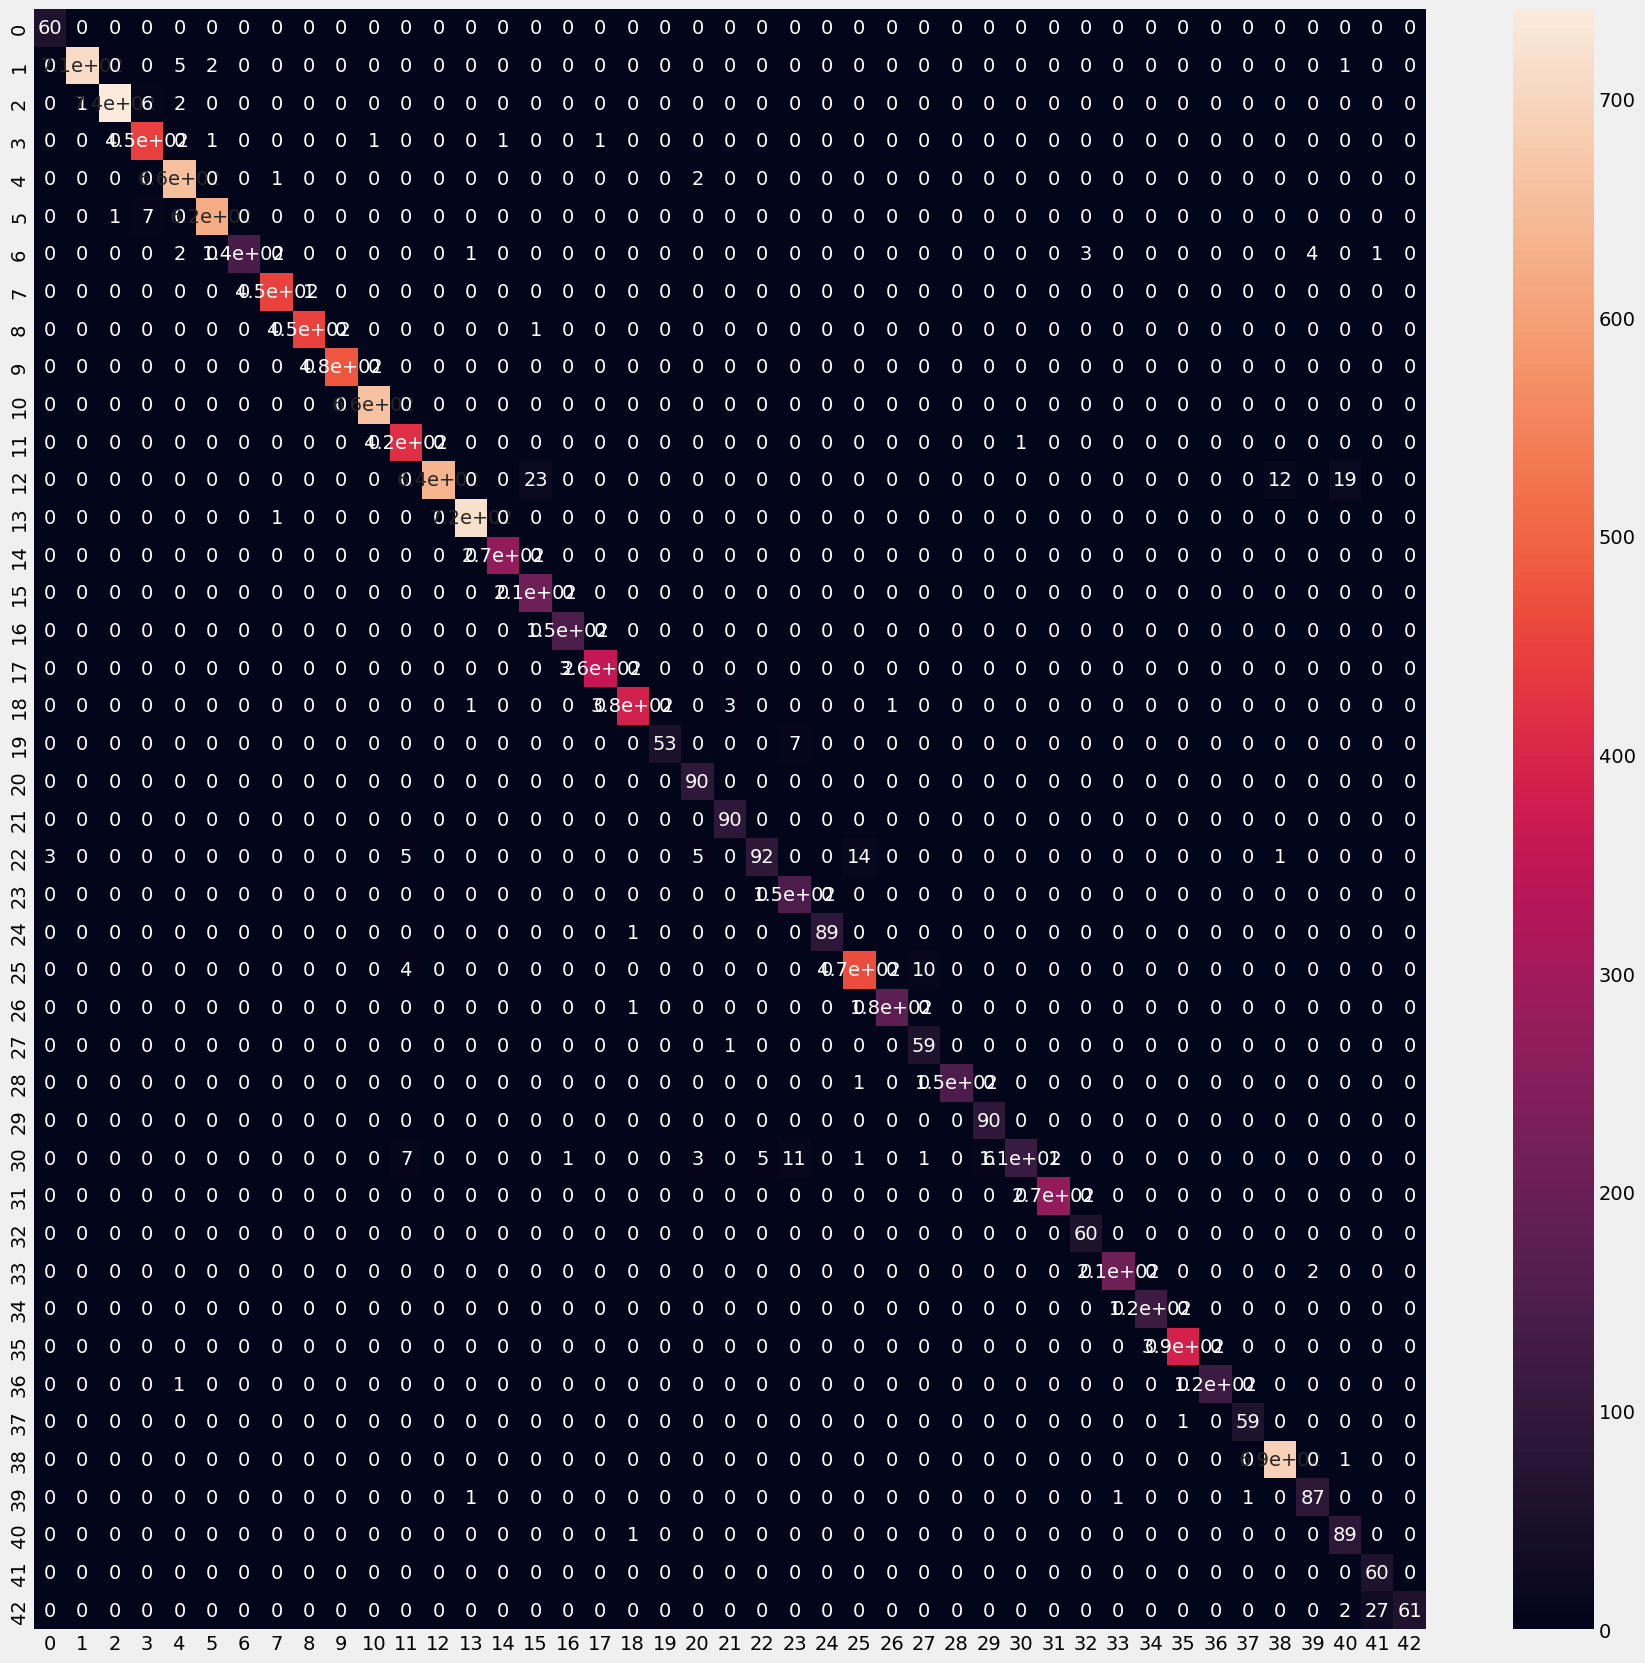

In [44]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## Classification report

In [46]:
# 将预测概率转换为类别索引
pred_classes = np.argmax(pred, axis=1)

# 输出分类报告
print(classification_report(labels, pred_classes))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       1.00      0.99      0.99       720
           2       1.00      0.99      0.99       750
           3       0.97      0.99      0.98       450
           4       0.99      1.00      0.99       660
           5       1.00      0.99      0.99       630
           6       1.00      0.93      0.96       150
           7       1.00      1.00      1.00       450
           8       1.00      1.00      1.00       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.96      1.00      0.98       420
          12       1.00      0.92      0.96       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.90      1.00      0.95       210
          16       0.98      1.00      0.99       150
          17       1.00    

## Predictions on Test Data

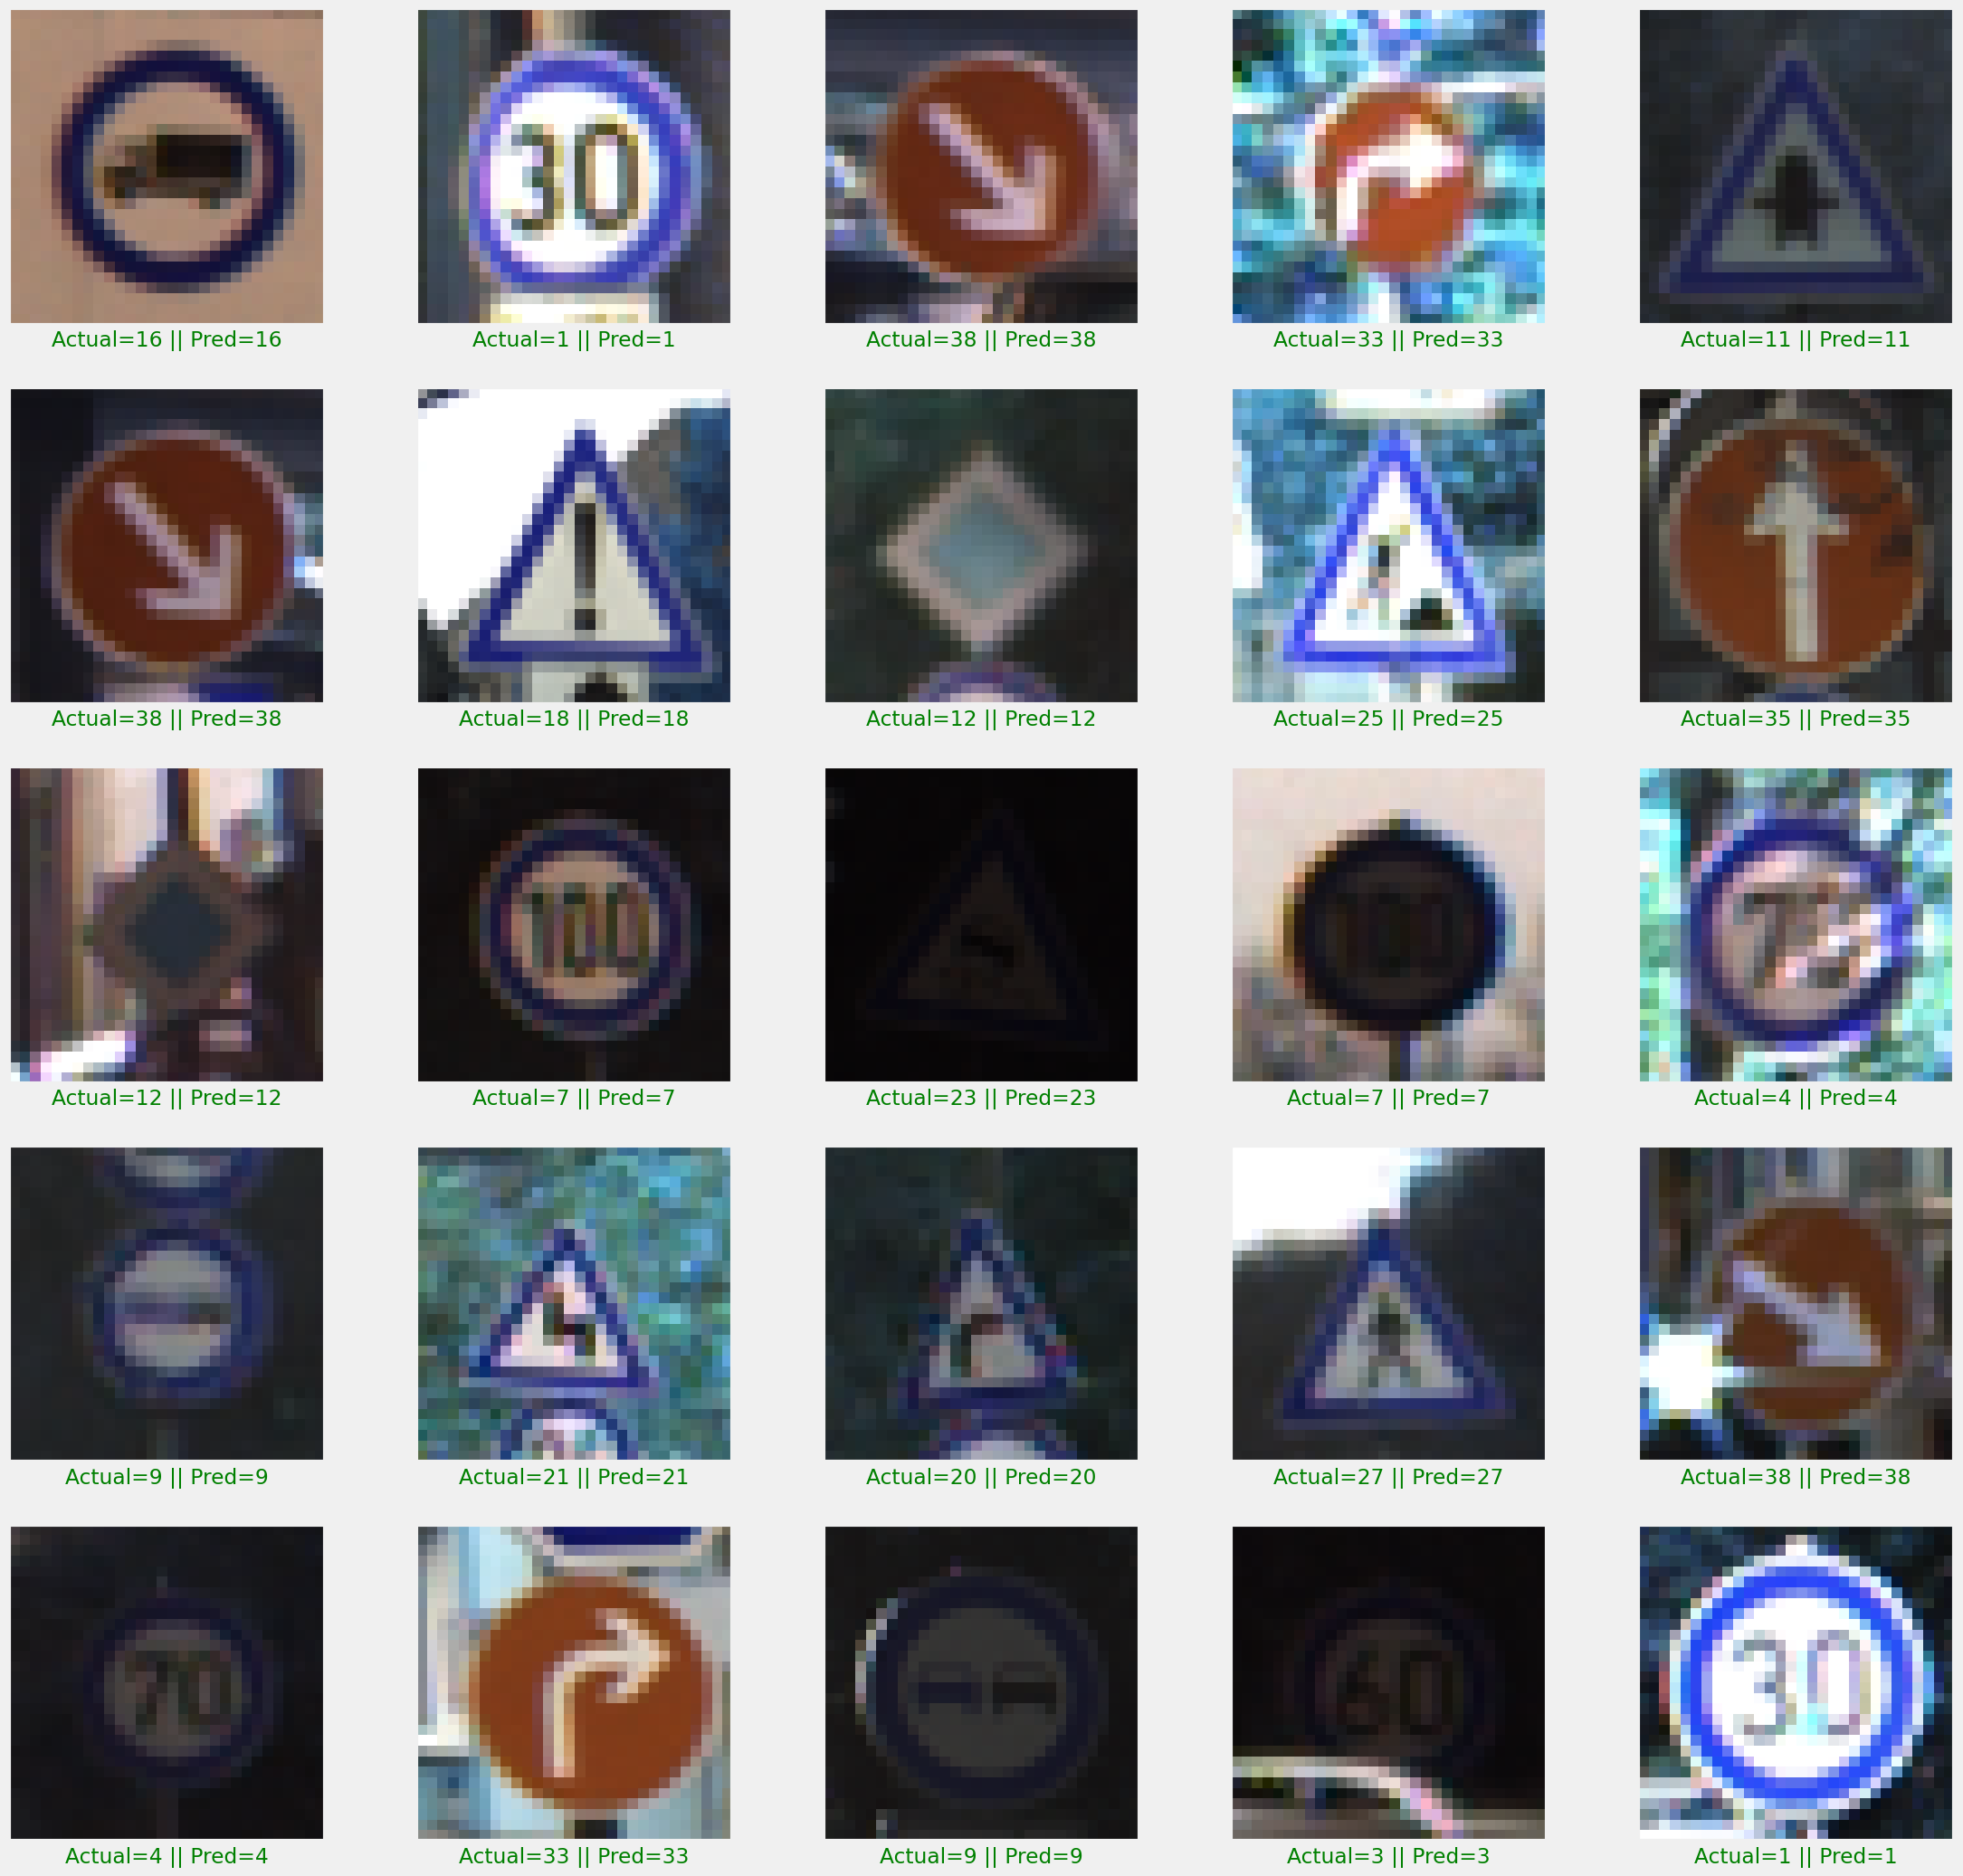

In [48]:
pred_classes = np.argmax(pred, axis=1)

plt.figure(figsize = (25, 25))
start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred_classes[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [50]:
model.save('/Users/zayn/Desktop/CS415G/Traffic-Sign-Classification/zz/sf_model.h5')
